# Week 8- Credit Card Fraud Detection

## Introduction

이번 데이터는 2013년 9월, 유럽 카드사 고객의 거래 데이터이다.  2일 간 284,807의 거래가 발생했고, 이중 492개의 사기였다. 개인정보 문제로 변수들이 모두 scaling(PCA) 되어있으며, 변수의 이름도 가려져있다. 이런 불균형적인 거래내역을 분석하며 Fraud와 Non-Fraud를 잘 분류하는 것이 커널의 최종 목적이다. 모델을 로지스틱 회귀와 LightGBM을 사용할 것이다.

## Loading Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('Credit card Shape : ', df.shape)

Credit card Shape :  (284807, 31)


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

모든 데이터가 float, int형으로 구성되어있음. 앞서 말했듯 PCA를 했기 때문이다.

- PCA : 다차원의 데이터에서 차원 감소를 시켜주는 것.

In [6]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

원본 데이터는 유지하고, 전처리를 위해 df_copy를 생성

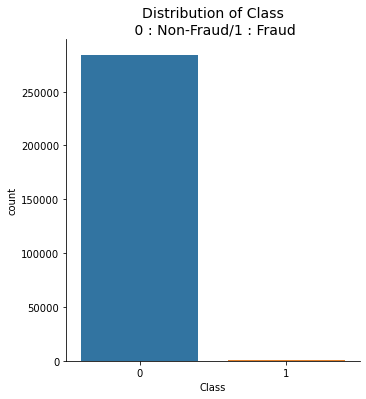

In [7]:
sns.catplot(x = 'Class', data = df, kind = 'count')
plt.title('Distribution of Class\n 0 : Non-Fraud/1 : Fraud', size = 14)
plt.show()

In [8]:
# train-test셋을 나누는 함수
def get_train_test_dataset(df = None):
    df_copy = get_preprocessed(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_target = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    return X_train, X_test, y_train, y_target

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

stratify = y_target을 지정함으로 y_target(label) 분포에 따라 추출하였음.

In [9]:
print('Proportion of Train data label : \n{}'.format(y_train.value_counts() / y_train.shape[0] * 100))
print()
print('Proportion of Test data label : \n{}'.format(y_test.value_counts() / y_test.shape[0] * 100))

Proportion of Train data label : 
0    99.827451
1     0.172549
Name: Class, dtype: float64

Proportion of Test data label : 
0    99.826785
1     0.173215
Name: Class, dtype: float64


train과 test의 class 비율은 거의 차이나지 않으며, 모두 불균형적인 데이터이다.

In [10]:
# 평가함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    plt.figure(figsize = (4,4))
    
    # 평가
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    # heatmap
    sns.heatmap(confusion_matrix(y_test, pred), cmap = 'Blues', annot = True, fmt = '.2f')
    print('accuracy : {0: .4f}, precision : {1: .4f}, recall : {2: .4f},  F1 : {3: .4f}, AUC : {4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

<b> Logistic regression </b>

accuracy :  0.9992, precision :  0.8750, recall :  0.6149,  F1 :  0.7222, AUC :  0.9570


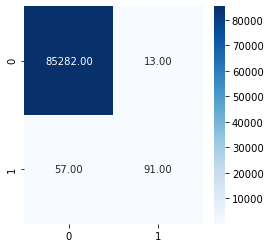

In [11]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

about Confusion Matrix : https://sumniya.tistory.com/26

In [12]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

<b> LightGBM train/ predict/ evaluation </b>

boost_from_average가 True일 때, 레이블 값이 극도로 불균형 분포를 이루는 경우엔 recall 및 roc_auc 성능이 매주 저하된다.

[LightGBM] [Warning] Unknown parameter: n_estimator
accuracy :  0.9995, precision :  0.9483, recall :  0.7432,  F1 :  0.8333, AUC :  0.9717


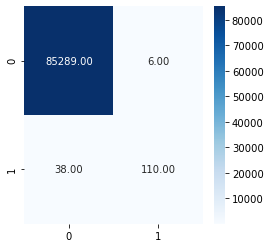

In [13]:
lgbm_clf = LGBMClassifier(n_estimator = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

## Transforming distribution of important features

<Figure size 720x288 with 0 Axes>

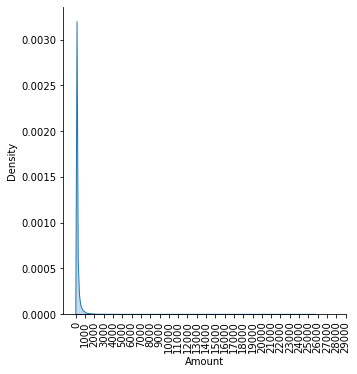

In [14]:
plt.figure(figsize = (10,4))
sns.displot(df['Amount'], kind = 'kde', fill = True)
plt.xticks(range(0, 30000, 1000), rotation = 90)
plt.show()

상당히 skew된 분포를 보인다.

### Standard Scaler

In [15]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount']).values.reshape(-1,1)
    
    # 변환된 Amount를 Amount_scaled로 피처명 변경 , Dataframe 맨 앞 컬럼에 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 amount 피쳐 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace =True)
    return df_copy

### Evaluation models After Standard Scaling

### Logistic Regression ###
accuracy :  0.9992, precision :  0.8750, recall :  0.6149,  F1 :  0.7222, AUC :  0.9570
 ### LightGBM ###
accuracy :  0.9995, precision :  0.9573, recall :  0.7568,  F1 :  0.8453, AUC :  0.9790


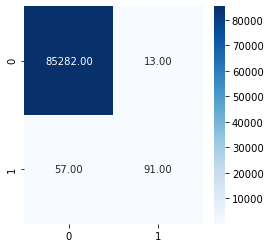

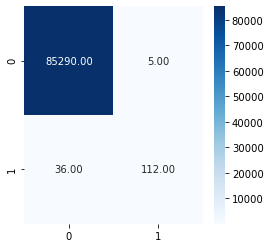

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### Log 변환

In [17]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

### Logistic Regression ###
accuracy :  0.9991, precision :  0.8034, recall :  0.6351,  F1 :  0.7094, AUC :  0.9316
 ### LightGBM ###
accuracy :  0.9995, precision :  0.9576, recall :  0.7635,  F1 :  0.8496, AUC :  0.9796


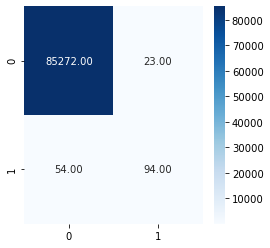

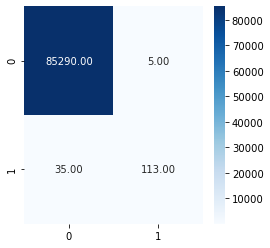

In [18]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

## Delete Outlier

<b> Correlation </b>

 -  Wrong Correlations : 우리가 'V'라는 feature가 어떤걸 나타내는지 모른다고 해도, target의 결과에 영향을 끼치는지 알 수는 있다. 하지만 불균형한 데이터셋에선 정확한 상관관계를 파악하기 힘들다.

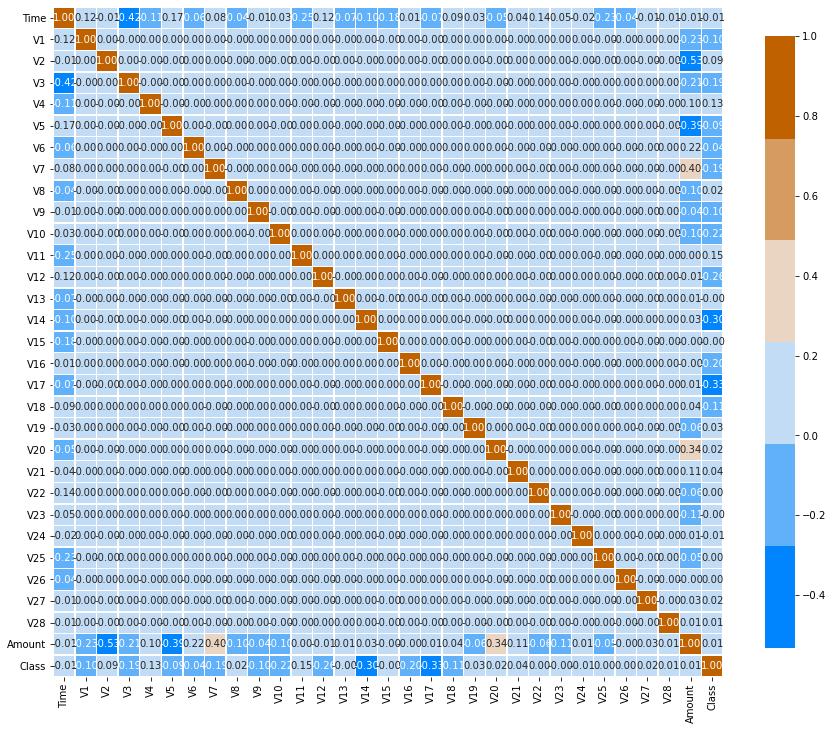

In [19]:
def plot_corr(data):
    plt.figure(figsize =(15,15))
    correlation = data.corr()
    cmap = sns.diverging_palette(250,50,250)
    sns.heatmap(correlation, cmap = cmap, annot = True, fmt = '.2f', square=True, linewidths='.5', cbar_kws={'shrink' : 0.75})
    plt.show()
plot_corr(df)

In [20]:
# 양의 상관계수가 강한 변수들
print('Most Positive Correlations: \n', df.corr().sort_values('Class', ascending = False)['Class'][:10])

# 음의 상관계수가 약한 변수들
print('\nMost Negative Correlations: \n', df.corr().sort_values('Class', ascending = True)['Class'][:10])

Most Positive Correlations: 
 Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64

Most Negative Correlations: 
 V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V18   -0.111485
V1    -0.101347
V9    -0.097733
Name: Class, dtype: float64


Class와 상관관계가 강한 V14, V17의 Outlier를 제거하도록 한다.

<b> Outlier index 반환 </b>

In [21]:
def get_outlier(df = None, column = None, weight = 1.5):
    # Fraud에 해당하는 columns 데이터만 추출, Q1, Q3 지점을 np.percentile로 구함.
    fraud = df[df['Class'] == 1][column]
    Q1 = np.percentile(fraud.values, 25)
    Q3 = np.percentile(fraud.values, 75)
    
    # Outlier를 구함
    IQR = Q3 - Q1
    IQR_weight = IQR * weight
    lowest_val = Q1 - IQR_weight
    highest_val = Q3 + IQR_weight
    
    # Max보다 크거나, Min보다 작은 값을 Outlier로 설정
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [22]:
outlier_index = get_outlier(df = df, column = 'V14', weight = 1.5)
print('Outlier index: ', outlier_index)

Outlier index:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


### Logistic Regression ###
accuracy :  0.9993, precision :  0.8839, recall :  0.6781,  F1 :  0.7674, AUC :  0.9609
 ### LightGBM ###
accuracy :  0.9996, precision :  0.9603, recall :  0.8288,  F1 :  0.8897, AUC :  0.9780


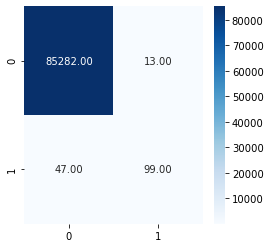

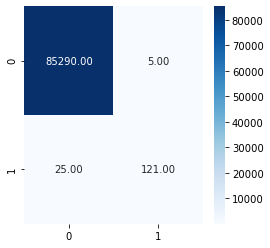

In [23]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop('Time', axis = 1, inplace = True)
    
    # Del Outlier
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

이상치 제거는 모델 성능에 좋은 것을 확인 할 수 있다.

## SMOTE Oversampling

In [24]:
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전, 학습용 피처/레이블 데이터: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후, 학습용 피처/레이블 데이터: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전, 학습용 피처/레이블 데이터:  (199362, 30) (199362,)
SMOTE 적용 후, 학습용 피처/레이블 데이터:  (398040, 30) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


SMOTE 기법을 통해 불균형한 target을 균형적으로 처리함.

accuracy :  0.9722, precision :  0.0536, recall :  0.9178,  F1 :  0.1012, AUC :  0.9715


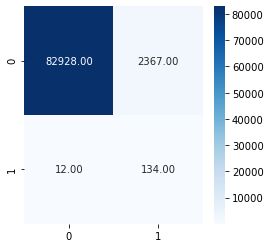

In [25]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train = y_train_over, tgt_test=y_test)

recall이 상승했음.

### Precision Recall Trade-off Plot

In [26]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

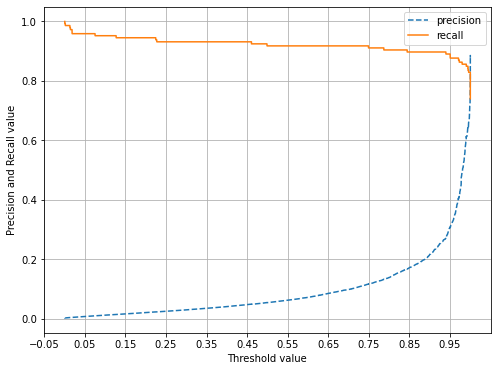

In [27]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

accuracy :  0.9996, precision :  0.9173, recall :  0.8356,  F1 :  0.8746, AUC :  0.9814


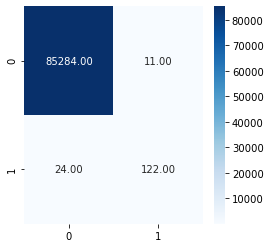

In [28]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

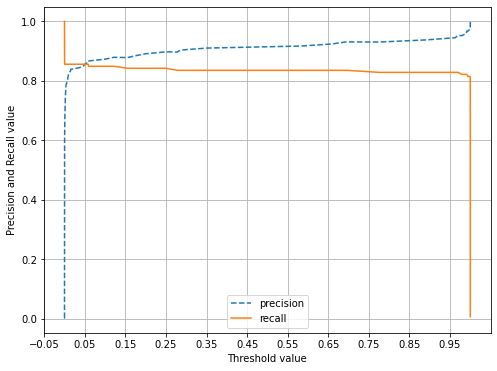

In [29]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1])

## Reference

PCA에 대하여 : https://angeloyeo.github.io/2019/07/27/PCA.html